In [82]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline
plt.style.use('seaborn-dark-palette')

import plotly
import plotly.express as px
DATA="raw"

/var/folders/d7/wr0_38q17_38rmx4dysxdyfh0000gn/T/ipykernel_6959/792964846.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


## Load data

In [83]:
df = pd.read_excel("../data/raw/DataCorpus_classfied_중분류_2차 연구.xlsx")

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [84]:
def add_type_column(df):
    ops = df.iloc[:, 5:-3]
    print(ops.info())
    op_type = ops[ops.columns[1:]].apply(
        lambda x: ','.join(x.dropna().astype(str)),
        axis=1
    )
    op_type=op_type.str.lower()
    df["op_type"] = op_type
    op_type = pd.DataFrame(op_type.unique(), columns=["op_type"]).sort_values(
        by="op_type",
        key=lambda x: x.str.len(),
        ignore_index=True
        )
    op_type["op_id"] = op_type.index
    op_type.to_excel("../data/processed/op_type.xlsx")
    df = df.merge(op_type, how='left', on="op_type")
    df.to_excel("../data/processed/corpora_w_op_type.xlsx")

    return df

In [85]:
df = add_type_column(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Question type  227 non-null    object
 1   ordinary1      227 non-null    object
 2   ordinary2      215 non-null    object
 3   ordinary3      182 non-null    object
 4   ordinary4      102 non-null    object
 5   ordinary5      56 non-null     object
 6   ordinary6      27 non-null     object
 7   ordinary7      13 non-null     object
 8   ordinary8      3 non-null      object
 9   ordinary9      3 non-null      object
 10  ordinary10     2 non-null      object
 11  ordinary103    1 non-null      object
 12  ordinary102    1 non-null      object
 13  ordinary11     1 non-null      object
dtypes: object(14)
memory usage: 25.0+ KB
None


# 1. Type count from raw data
 Visualize initail labelled data

/Users/heejinchae/opt/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


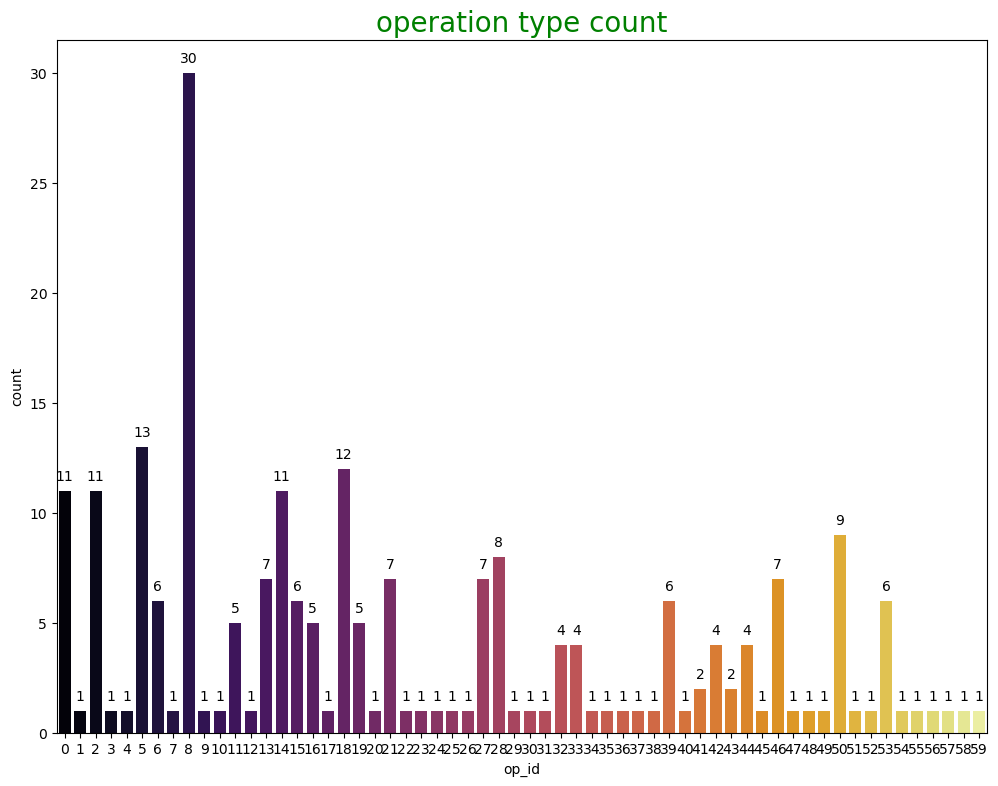

In [86]:
plt.figure(figsize=[12,9])
plot = sns.countplot(df["op_id"], palette = 'inferno')
for p in plot.patches:
    plot.annotate(format(p.get_height(),), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('operation type count', fontdict={'fontsize': 20, 'fontweight': 5, 'color': 'Green'})
#plt.xticks(rotation=90)
plt.savefig("../figures/class_and_count_initial.png", bbox_inches='tight')
plt.show()

# 2. Drop classes only with a value
 If a data is the only one in category, dropped <br />
 클래스에 해당하는 데이터가 n개 인것은 제거하기로 함. 여기서는 2개 이상으로 설정했음
 

In [87]:
df= df.groupby("op_id").filter(lambda x: len(x) >2)
df.to_excel(f"../data/processed/corpora_unique_ops_dropped_wo_paraph.xlsx")

In [88]:
train_df = df.groupby('op_id', group_keys=False).apply(
         lambda x: x.sample(frac=0.55,
                            random_state=533314
                            )
)
test_df = df[~df.index.isin(train_df.index)]
train_df["for train"] = True
test_df["for train"] = False
train_test_raw = pd.concat([train_df, test_df],
axis=0,
ignore_index=True)

train_to_csv = train_df[["op_id", "Question"]].copy()
train_to_csv.to_csv("../data/input/hugging_face/train_raw.csv",index=False)
test_to_csv = test_df[["op_id","Question"]].copy()
test_to_csv.to_csv("../data/input/hugging_face/test.csv",index=False)
train_test_raw.to_excel("../data/input/train_test_raw.xlsx")

/var/folders/d7/wr0_38q17_38rmx4dysxdyfh0000gn/T/ipykernel_6959/1679096110.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["for train"] = False


In [89]:
class_vs_question = train_test_raw[["op_id","Question","for train"]].copy()
class_vs_question = class_vs_question[class_vs_question["for train"]==True]
class_vs_question = class_vs_question.drop(columns=["for train"])
class_vs_question.to_csv("../../../eda_nlp/data/class_vs_question.csv",sep="\t",header=False,index=False)

In [90]:
eda_df=pd.read_csv("../../../eda_nlp/data/eda_class_vs_question.csv",sep="\t")
eda_df.columns=["op_id","Question"]
eda_df.to_csv("../data/input/hugging_face/train_eda.csv",index=False)
eda_df["for train"]=True
train_test_eda = pd.concat([test_df, eda_df],
axis=0,
ignore_index=True)
train_test_eda.to_excel("../data/input/train_test_eda.xlsx")